In [1]:
import os
import random
import tensorflow as tf
from keras import backend as K

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import clear_output

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

#%matplotlib inline
%matplotlib widget

seed_value = 32

# 1. Установим начальное значение для генератора случайных чисел в Python
random.seed(seed_value)

# 2. Установим начальное значение для генератора случайных чисел в Numpy
np.random.seed(seed_value)

# 3. Установим начальное значение для генератора случайных чисел в tensorflow 
tf.random.set_seed(seed_value)

# 4. Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# IO utils


In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

In [3]:
def callbacks(lr):
   
    # сохранение лучшей модели
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        os.path.join('../data', 'best_model' +'.hdf5'), 
        monitor='val_mse', 
        verbose=1, 
        mode='min', 
        save_best_only=True
    )

    # остановка обучения при отсутствии улучшения заданной метрики
    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_mse', 
        mode='min', 
        patience=50, # 50
        restore_best_weights=True
    )

    # снижение learning rate при отсутствии улучшения заданной метрики 
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_mse', 
        mode='min',  
        factor=0.5,  # 0.5
        patience=20,  # 20
        verbose=1, 
        min_lr=lr/1000
    )
    
    return [checkpoint, earlystop, reduce_lr]

In [4]:
def reset_random_seeds(seed_value):
    """Функция задания seed
    """
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [6]:
palm_file_2_1 = './data/sprint2_pilote1_gestures.palm'

gestures_2_1 = read_omg_csv(palm_file_2_1, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

print(gestures_2_1.shape)
gestures_2_1.head(3)

train_test_div_num = int(len(gestures_2_1)*0.8)
gestures_train_2_1 = gestures_2_1.iloc[:train_test_div_num]
gestures_test_2_1 = gestures_2_1.iloc[train_test_div_num:]
print(gestures_train_2_1.shape, gestures_test_2_1.shape)

(37610, 65)
(30088, 65) (7522, 65)


In [7]:
palm_file_2_2 = './data/sprint2_pilote2_gestures.palm'
gestures_2_2 = read_omg_csv(palm_file_2_2, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

print(gestures_2_2.shape)
gestures_2_2.head(3)

train_test_div_num = int(len(gestures_2_2)*0.8)
gestures_train_2_2 = gestures_2_2.iloc[:train_test_div_num]
gestures_test_2_2 = gestures_2_2.iloc[train_test_div_num:]
print(gestures_train_2_2.shape, gestures_test_2_2.shape)

(26650, 65)
(21320, 65) (5330, 65)


In [ ]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# [y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures_train_2_1.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [8]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == gestures_train_2_1.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"GLOVE_CH: {list(GLOVE_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


In [9]:
# fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
# plt.sca(axx[0])
# plot_train = plt.plot(gestures['ts'].values, gestures[OMG_CH].values)
# plt.title('OMG')

# plt.sca(axx[1])
# plot_train = plt.plot(gestures['ts'].values, gestures[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 100)
# plt.yticks(-np.arange(len(GLOVE_CH)) * 100, GLOVE_CH)
# plt.title('Fingers')
# plt.xlabel('Timesteps')

# plt.suptitle('Train and test gestures')
# plt.tight_layout()

### Protocol

In [10]:
gestures_protocol_2_1 = pd.read_csv(f'{palm_file_2_1}.protocol.csv')
gestures_protocol_2_1.head(3)

,epoch,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
gestures_protocol_2_2 = pd.read_csv(f'{palm_file_2_2}.protocol.csv')
gestures_protocol_2_2.head(3)

,epoch,Thumb,Index,Middle,Ring,Pinky,Thumb_stretch,Index_stretch,Middle_stretch,Ring_stretch,Pinky_stretch,Pronation
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# add OPEN to protocol
mask_open_1 = (gestures_protocol_2_1[['Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch']] == 1.0).all(axis=1)
gestures_protocol_2_1.loc[mask_open_1, ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']] = -0.5

mask_open_2 = (gestures_protocol_2_2[['Thumb_stretch', 'Index_stretch', 'Middle_stretch', 'Ring_stretch', 'Pinky_stretch']] == 1.0).all(axis=1)
gestures_protocol_2_2.loc[mask_open_2, ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']] = -0.5

In [13]:
gestures_ext_2_1 = pd.merge(
    gestures_2_1,
    gestures_protocol_2_1,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_ext_2_1.isna().sum().unique()

array([0], dtype=int64)

In [14]:
gestures_ext_2_2 = pd.merge(
    gestures_2_2,
    gestures_protocol_2_2,
    how='left',
    left_on='SYNC',
    right_on='epoch',
)

gestures_ext_2_2.isna().sum().unique()

array([0], dtype=int64)

In [15]:
# fig, axx = plt.subplots(3, 1, sharex=True, figsize=(12, 8))
# plt.sca(axx[0])
# plot_train = plt.plot(gestures_ext['ts'].values, gestures_ext[OMG_CH].values)
# plt.title('OMG')

# plt.sca(axx[1])
# plot_train = plt.plot(gestures_ext['ts'].values, gestures_ext[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 200)
# plt.yticks(-np.arange(len(GLOVE_CH)) * 200, GLOVE_CH)
# plt.title('Glove')

# plt.sca(axx[2])

# plot_train = plt.plot(
#     gestures_ext['ts'].values,
#     gestures_ext[['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']].values - np.arange(5) * 2
# )

# plt.yticks(-np.arange(5) * 2, ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky'])
# plt.xlabel('Timesteps')
# plt.title('Protocol')

# plt.suptitle('Train and test gestures')
# plt.tight_layout()

In [16]:
# # Проверка на взаимную корреляцию OMG и GLOVE, ACC_CH и GLOVE, GYR_CH и GLOVE
# gestures_train = pd.read_csv('../data/gestures_train.csv')

# OMG_CH = [str(i) for i in range(50)]
# ACC_CH = ['ACC0', 'ACC1', 'ACC2']
# GYR_CH = ['GYR0', 'GYR1', 'GYR2']
# # ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
# GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']


# def norm_cross_corr(set1, set2):
#     # Функция поиска нормализованной взаимной корреляции в Python: statsmodels.tsa.stattools.ccf
#     return np.sum(set1 * set2) / (np.linalg.norm(set1) * np.linalg.norm(set2))


# X_train = gestures_train[OMG_CH].values # ACC_CH # GYR_CH
# #scaler = MinMaxScaler()
# #X_train = scaler.fit_transform(X_train)
# X_train = pd.DataFrame(X_train, columns=OMG_CH) # ACC_CH # GYR_CH

# y_train = gestures_train[GLOVE_CH] #/100

# for glove in GLOVE_CH[:-1]:
#     for omg in OMG_CH: # ACC_CH # GYR_CH
#         y_array = y_train[glove]
#         X_array = gestures_train[omg]
#         n_cross_corr = norm_cross_corr(X_array, y_array)
#         if n_cross_corr > 0.64:
#             print(omg, glove)
#         #print(f"Normalized Cross Correlation {omg}, {glove}: {n_cross_corr}")
#     print()
        

# Preprocessing

In [17]:
def get_diff(arr, shift_=1):
    diff_arr = np.vstack([np.zeros((shift_, arr.shape[1])), (arr-np.roll(arr, shift_, axis=0))[shift_:]])
    return diff_arr
def get_std(arr, window=3):
    arr_3d = np.lib.stride_tricks.sliding_window_view(arr, window_shape=window, axis=0)
    return np.vstack([np.zeros((window-1, arr.shape[1])), np.std(arr_3d, 2)])

In [18]:
pd.concat([gestures_train_2_1, gestures_train_2_2]).reset_index(drop=True)

,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,10,8,29,2846,2929,2873,2598,24,8,6,...,32,37,50,54,44,5,0,0,0,1174956
1,10,8,28,2846,2931,2873,2597,24,8,13,...,31,37,50,54,44,5,0,0,0,1174989
2,16,8,29,2847,2930,2875,2598,24,8,6,...,31,37,50,54,44,5,0,0,0,1175022
3,10,8,29,2847,2930,2875,2598,25,8,5,...,30,37,50,54,44,5,0,0,0,1175055
4,0,8,29,2845,2927,2870,2594,24,8,6,...,30,37,50,54,44,5,0,0,0,1175088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51403,6,8,55,3375,3829,3831,2273,11,6,5,...,-1,12,18,26,27,28,0,0,173,865185
51404,11,8,56,3368,3837,3827,2261,11,7,4,...,-1,12,18,27,33,29,0,0,173,865218
51405,10,7,53,3347,3846,3820,2238,10,6,5,...,-2,12,18,29,44,30,0,0,173,865251
51406,11,8,50,3317,3853,3821,2162,9,6,6,...,0,12,19,34,61,33,0,0,173,865284


In [19]:
gestures_train = pd.concat([gestures_train_2_1, gestures_train_2_2]).reset_index(drop=True)
X_train = gestures_train[OMG_CH].values
diff_1_train = get_diff(X_train, 1)
X_train = np.hstack([X_train,
                     diff_1_train,
                    ])

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
#X_train = X_train/4096


y_train = gestures_train[GLOVE_CH].values
y_train = y_train/100

X_train.shape, y_train.shape

((51408, 100), (51408, 6))

# Dataset forming

In [20]:
duration = 60
ts_events = np.arange(0, len(X_train), 10)

X_train_nn = [X_train[ts_event : ts_event + duration] for ts_event in ts_events]
y_train_nn = [y_train[ts_event : ts_event + duration] for ts_event in ts_events]

X_train_nn = np.array([arr for arr in X_train_nn if arr.shape == X_train_nn[0].shape])
y_train_nn = np.array([arr for arr in y_train_nn if arr.shape == y_train_nn[0].shape])

print(X_train_nn.shape, y_train_nn.shape)

(5135, 60, 100) (5135, 60, 6)


# Modeling

## Architecture

In [22]:
hidden_size = 100
#_, n_timesteps, n_channels = X_train_nn.shape
n_timesteps = None
n_channels = X_train_nn.shape[-1]
output_units = y_train_nn.shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")

input_channels = x = tf.keras.layers.Input(shape=(None, n_channels))

x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.LSTM( 
    units=hidden_size,
    #recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
    return_sequences=True,
)(x)

x = tf.keras.layers.Dropout(0.5)(x) 

output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
        units=output_units,
        activation='relu',
    ))(x)

model = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model"
)

model.summary()


tf.keras.backend.clear_session()

reset_random_seeds(seed_value)

model.compile(
    loss="mean_squared_error", 
    metrics=['mse'], 
    #optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), #AdamW
    optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=0.001),
)

input_shape = (None, 100) | output_units = 6
Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 100)]       0         
                                                                 
 batch_normalization (BatchN  (None, None, 100)        400       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, None, 100)         80400     
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 time_distributed (TimeDistr  (None, None, 6)          606       
 ibuted)                                                         
                                                                 
Total params: 81

## Model train

In [23]:
history = model.fit(
    X_train_nn,
    y_train_nn, 
    epochs=500,
    validation_split=0.2,
    verbose=1,
    callbacks=callbacks(1e-04)
)

y_pred_train_nn = model.predict(X_train_nn)
print(y_pred_train_nn.shape)

Epoch 1/500
127/129 [============================>.] - ETA: 0s - loss: 0.0461 - mse: 0.0461
Epoch 1: val_mse improved from inf to 0.06337, saving model to ../data\best_model.hdf5
129/129 [==============================] - 6s 34ms/step - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0634 - val_mse: 0.0634 - lr: 0.0010
Epoch 2/500
127/129 [============================>.] - ETA: 0s - loss: 0.0198 - mse: 0.0198
Epoch 2: val_mse improved from 0.06337 to 0.02332, saving model to ../data\best_model.hdf5
129/129 [==============================] - 4s 31ms/step - loss: 0.0198 - mse: 0.0198 - val_loss: 0.0233 - val_mse: 0.0233 - lr: 0.0010
Epoch 3/500
128/129 [============================>.] - ETA: 0s - loss: 0.0143 - mse: 0.0143
Epoch 3: val_mse improved from 0.02332 to 0.01205, saving model to ../data\best_model.hdf5
129/129 [==============================] - 4s 31ms/step - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0120 - val_mse: 0.0120 - lr: 0.0010
Epoch 4/500
127/129 [============================>

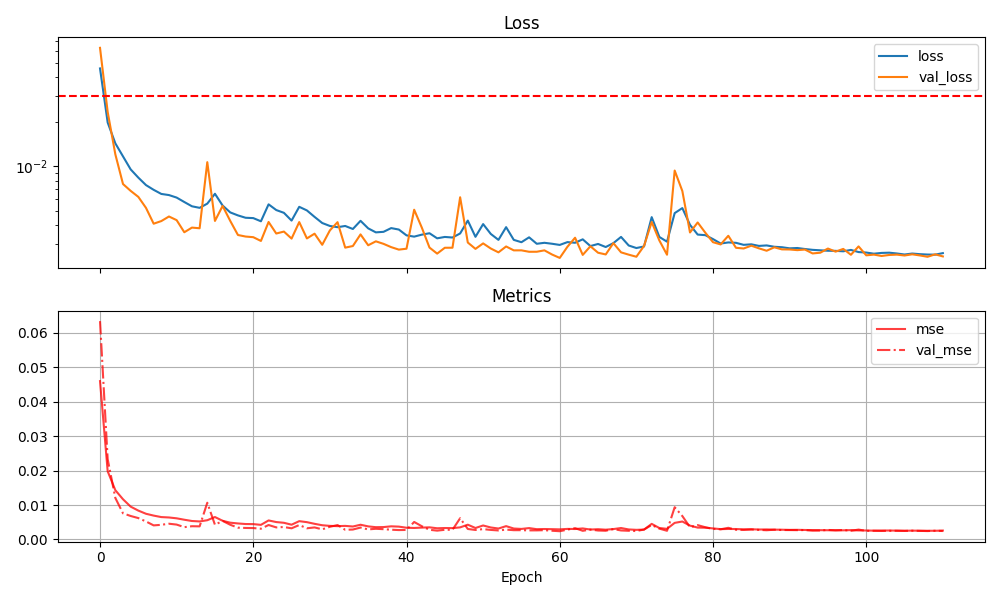

In [24]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
plt.sca(axx[0])
plt.plot(history.history['loss'],     label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.axhline(0.03, color='r', ls='--')
plt.yscale('log')
plt.title('Loss')
plt.legend()

plt.sca(axx[1])
plt.plot(history.history['mse'],    c='r', alpha=0.75, label='mse')
plt.plot(history.history['val_mse'],    '-.', c='r', alpha=0.75, label='val_mse')
plt.grid()
#plt.axhline(0.95, color='r', ls='--')
# plt.ylim(0.6, 1.0)
# plt.yscale('log')
plt.title('Metrics')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()

## Visualisation

In [ ]:
# i = 25

# fig, axx = plt.subplots(3, 1, sharex=True, figsize=(10, 6))

# axx[0].plot(X_train_nn[i])
# axx[0].set_title('OMG')

# axx[1].imshow(y_train_nn[i].T, origin="lower")
# axx[1].set_aspect('auto')
# axx[1].set_title('Class/Command')
# axx[1].set_yticks(np.arange(6), GLOVE_CH)

# axx[2].imshow(y_pred_train_nn[i].T, origin="lower") # , vmin=-0.5, vmax=0.5
# axx[2].set_aspect('auto')
# axx[2].set_title('Model output')
# axx[2].set_yticks(np.arange(6), GLOVE_CH)
# axx[2].set_xlabel('Timestep')

# plt.suptitle(f'Train {i}')
# plt.tight_layout()

## Prediction

In [25]:
X_train = gestures_train[OMG_CH].values
diff_1_train = get_diff(X_train, 1)
X_train = np.hstack([X_train,
                     diff_1_train,
                    ])
X_train = scaler.transform(X_train)

y_train_true = gestures_train[GLOVE_CH]


y_pred_train = model.predict(X_train[None, :])[0]*100
print(y_pred_train.shape)

y_pred_train = pd.DataFrame(y_pred_train, columns=GLOVE_CH, index=gestures_train.index)

metrics_train = {col : mse(y_train_true[col], y_pred_train[col]) for col in GLOVE_CH}
metrics_train = pd.Series(metrics_train)

print('Train')
display(metrics_train)

1/1 [==============================] - 2s 2s/step
(51408, 6)
Train


ENC0    13.961501
ENC1     9.409495
ENC2    12.327720
ENC3    11.797387
ENC4    16.264791
ENC5     0.000000
dtype: float64

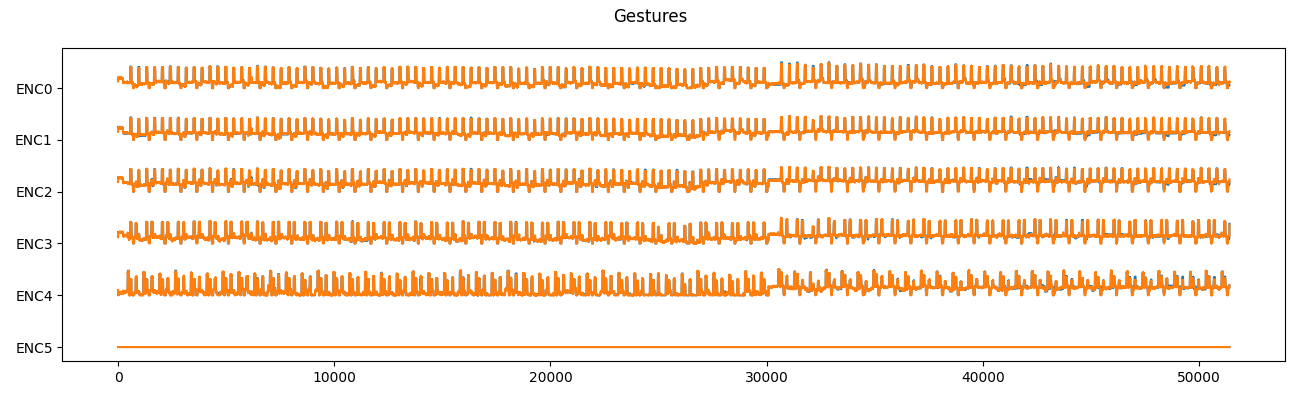

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(13, 4))

plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

p = plt.plot(gestures_train.index, gestures_train[GLOVE_CH].values + yticks, c='C0')

p = plt.plot(gestures_train.index, y_pred_train.values + yticks, c='C1', linestyle='-')

plt.yticks(yticks, GLOVE_CH)
plt.suptitle(f'Gestures')
plt.tight_layout()

## Test

In [26]:
gestures_test = pd.concat([gestures_test_2_1, gestures_test_2_2]).reset_index(drop=True)

X_test = gestures_test[OMG_CH].values
diff_1_test = get_diff(X_test, 1)
X_test = np.hstack([X_test,
                    diff_1_test,
                   ])
X_test = scaler.transform(X_test)
y_pred_test = model.predict(X_test[None, :])[0]*100
y_pred_test = pd.DataFrame(y_pred_test, columns=GLOVE_CH, index=gestures_test.index)

y_test_true = gestures_test[GLOVE_CH]

metrics_test = {col : mse(y_test_true[col], y_pred_test[col]) for col in GLOVE_CH}
metrics_test = pd.Series(metrics_test)

print('Test')
display(metrics_test)

1/1 [==============================] - 1s 540ms/step
Test


ENC0    33.018123
ENC1    17.537087
ENC2    28.766789
ENC3    30.942084
ENC4    50.308557
ENC5     0.000000
dtype: float64

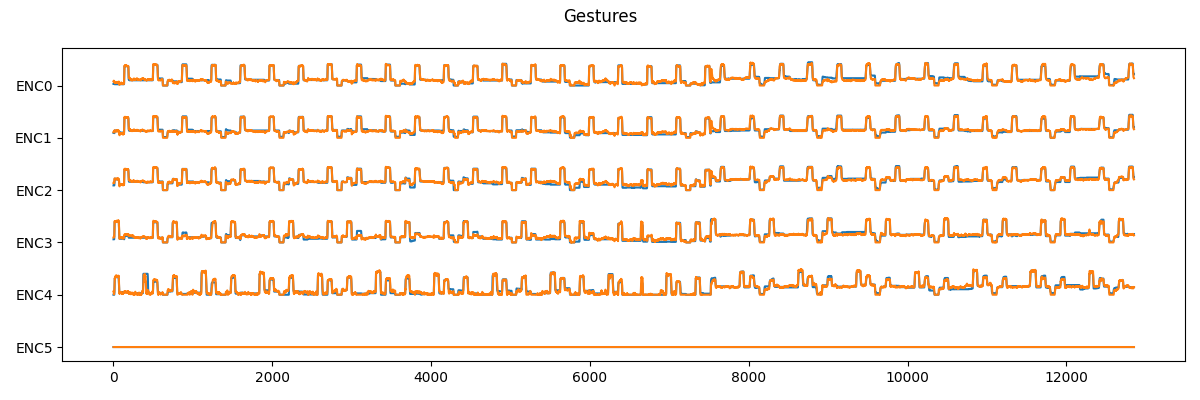

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

p = plt.plot(gestures_test.index, gestures_test[GLOVE_CH].values + yticks, c='C0')

p = plt.plot(gestures_test.index, y_pred_test.values + yticks, c='C1', linestyle='-')

plt.yticks(yticks, GLOVE_CH)
plt.suptitle(f'Gestures')
plt.tight_layout()

### Free_movements

In [ ]:
free_movements = pd.read_csv('../data/free_movements.csv')

X_free = free_movements[OMG_CH].values
diff_1_free = get_diff(X_free, 1)
X_free = np.hstack([X_free,
                    diff_1_free,
                   ])
X_free = scaler.transform(X_free)
y_pred_free = model.predict(X_free[None, :])[0] * 100
print(y_pred_free.shape)
y_pred_free = pd.DataFrame(y_pred_free, columns=GLOVE_CH, index=free_movements.index)

y_free_true = free_movements[GLOVE_CH]

metrics_free = {col : mse(y_free_true[col], y_pred_free[col]) for col in GLOVE_CH}
metrics_free = pd.Series(metrics_free)

print('free_movements')
display(metrics_free)

1/1 [==============================] - 2s 2s/step
(18338, 6)
free_movements


ENC0    194.231438
ENC1    449.104339
ENC2    352.280814
ENC3    310.025140
ENC4    585.334892
ENC5      0.000000
dtype: float64

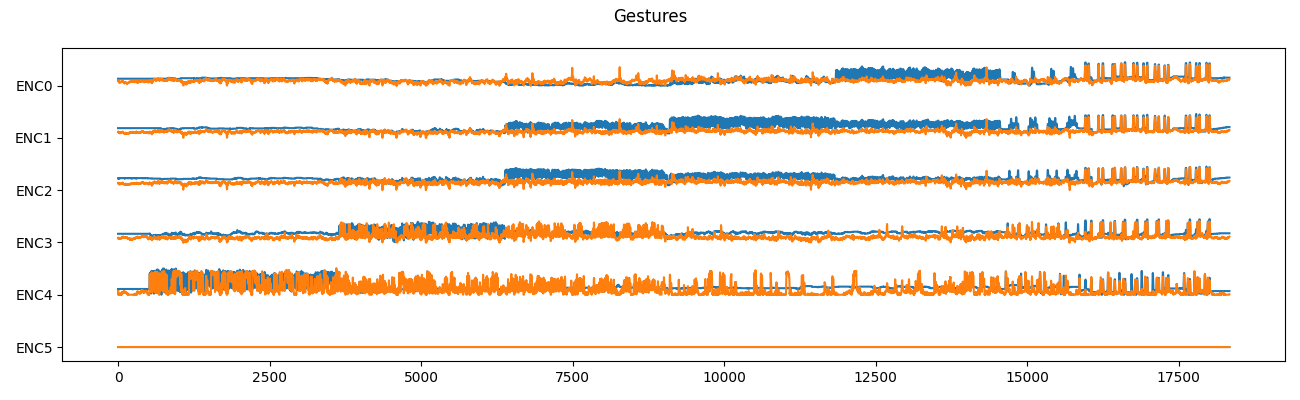

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(13, 4))

plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

p = plt.plot(free_movements.index, free_movements[GLOVE_CH].values + yticks, c='C0')

p = plt.plot(free_movements.index, y_pred_free.values + yticks, c='C1', linestyle='-')

plt.yticks(yticks, GLOVE_CH)
plt.suptitle(f'Gestures')
plt.tight_layout()

# Model for inference (stateful, one-timestep) 

In [27]:
model_input = tf.keras.Input(batch_shape=(1, 1, n_channels))

x = tf.keras.layers.BatchNormalization()(model_input)

x = tf.keras.layers.LSTM(
    units=hidden_size,
    return_sequences=True,
    #recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2),
    # return_state=True,
    # last state for each sample at index i in a batch will be used 
    # as initial state for the sample of index i in the following batch
    stateful=True,
    # speed-up a RNN, but more memory-intensive.
    # only suitable for short sequences.
    unroll=True
)(x)

x = tf.keras.layers.Dropout(0.5)(x)

model_output = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(
        units=output_units,
        activation='relu',
    ),
)(x)

model_stateful = tf.keras.Model(
    inputs=[model_input],
    outputs=[model_output],
    name='model_stateful'
)

model_stateful.set_weights(model.get_weights())
print(model_stateful.summary())

Model: "model_stateful"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(1, 1, 100)]             0         
                                                                 
 batch_normalization (BatchN  (1, 1, 100)              400       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (1, 1, 100)               80400     
                                                                 
 dropout (Dropout)           (1, 1, 100)               0         
                                                                 
 time_distributed (TimeDistr  (1, 1, 6)                606       
 ibuted)                                                         
                                                                 
Total params: 81,406
Trainable params: 81,206
Non-tr

## Architecture check

In [28]:
import time

In [29]:
np.set_printoptions(suppress=True, precision=8)

In [30]:
# toy-data
check_data = np.array([[i] * n_channels for i in range(1, 111)], dtype=float)
# real data
check_data = X_train[:10000]#.copy()
check_data = np.expand_dims(check_data, 0)
len_check_data = check_data.shape[1]

print(len_check_data, check_data.shape)
check_data[:, :3]

10000 (1, 10000, 100)


array([[[0.29411765, 0.36363636, 0.31868132, 0.51680506, 0.55650818,
         0.56743363, 0.80791867, 0.46153846, 0.38095238, 0.35294118,
         0.28205128, 0.2513089 , 0.36126329, 0.68078348, 0.35714286,
         0.33333333, 0.43605491, 0.64311953, 0.05063291, 0.08108108,
         0.22222222, 0.49773208, 0.48193336, 0.42647059, 0.35714286,
         0.26923077, 0.06649616, 0.33237548, 0.21374459, 0.08219178,
         0.19860184, 0.32098234, 0.19090909, 0.5       , 0.28571429,
         0.2       , 0.08403361, 0.1563981 , 0.31868979, 0.41539365,
         0.47826087, 0.56097561, 0.39285714, 0.44444444, 0.30769231,
         0.22727273, 0.26666667, 0.4516129 , 0.62857143, 0.74074074,
         0.5       , 0.5       , 0.46153846, 0.64651774, 0.55114401,
         0.61646728, 0.64451561, 0.51162791, 0.47368421, 0.5       ,
         0.5       , 0.65853659, 0.38913525, 0.67068646, 0.41176471,
         0.45283019, 0.3740458 , 0.53455929, 0.57467532, 0.4047619 ,
         0.35714286, 0.61761547, 0

In [31]:
y_pred = model.predict(check_data)
print(y_pred.shape)
# y_pred[:, :10]

1/1 [==============================] - 0s 412ms/step
(1, 10000, 6)


In [32]:
%%time

model_stateful.reset_states()

y_pred_stateful = []

time_start = time.time()

for i in range(check_data.shape[1]):
    embedding_stateful = model_stateful(check_data[:, [i]], training=False)
    y_pred_stateful.append(embedding_stateful.numpy())
    
time_end = time.time()
ts = (time_end - time_start) / len_check_data
    
y_pred_stateful = np.hstack(y_pred_stateful)

print(f"Avg time of {len_check_data} iters: {ts:.4f}")
print(y_pred_stateful.shape)
# y_pred_stateful[:, :10]

Avg time of 10000 iters: 0.0046
(1, 10000, 6)
CPU times: total: 46 s
Wall time: 46 s


In [ ]:
y_pred[:3]

array([[[0.26100755, 0.3168354 , 0.3736505 , 0.24020614, 0.20211187,
         0.        ],
        [0.27873155, 0.33646983, 0.3947403 , 0.23627168, 0.10886125,
         0.        ],
        [0.311585  , 0.36801744, 0.42397565, 0.26020434, 0.        ,
         0.        ],
        ...,
        [0.15575273, 0.19918033, 0.2661299 , 0.20233516, 0.8964787 ,
         0.        ],
        [0.16857137, 0.21110895, 0.27575988, 0.20919292, 0.8648801 ,
         0.        ],
        [0.16599298, 0.2094185 , 0.27763647, 0.20513974, 0.8729061 ,
         0.        ]]], dtype=float32)

In [ ]:
y_pred_stateful[:3]

array([[[0.26100755, 0.3168354 , 0.3736505 , 0.24020614, 0.20211187,
         0.        ],
        [0.27873155, 0.33646983, 0.3947403 , 0.23627168, 0.10886125,
         0.        ],
        [0.311585  , 0.36801744, 0.42397565, 0.26020434, 0.        ,
         0.        ],
        ...,
        [0.15575273, 0.19918033, 0.2661299 , 0.20233516, 0.8964787 ,
         0.        ],
        [0.16857137, 0.21110895, 0.27575988, 0.20919292, 0.8648801 ,
         0.        ],
        [0.16599298, 0.2094185 , 0.27763647, 0.20513974, 0.8729061 ,
         0.        ]]], dtype=float32)

In [ ]:
# CHECK equality of predictions
# ALL
print(np.allclose(y_pred, y_pred_stateful, atol=0.000001))

# EACH ONE
np.isclose(y_pred, y_pred_stateful).sum() / np.prod(y_pred_stateful.shape)

True


1.0

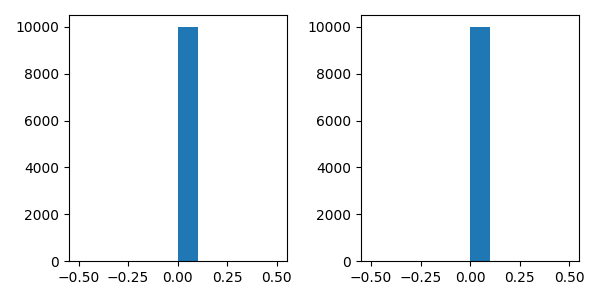

In [ ]:
y_pred_diff = y_pred - y_pred_stateful

fig, axx = plt.subplots(1, 2, figsize=(6, 3))

plt.sca(axx[0])
plt.hist(y_pred_diff[0, :, 0])
plt.sca(axx[1])
plt.hist(y_pred_diff[0, :, 1])

plt.tight_layout()

# Real-time inference

In [ ]:
import time
import serial
from IPython.display import clear_output

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [34]:
# def preprocessing(x, scaler=scaler):
#     # x - sample vector
#     #y = x
#     #y = y / 4096
#     y = scaler.transform(x.reshape(1, -1))[0]
#     return y
buff = np.zeros((6,50))

def preprocessing(x, buff=buff, scaler=scaler):
    buff[5], buff[4], buff[3], buff[2], buff[1] = buff[4], buff[3], buff[2], buff[1], buff[0]
    #x - sample vector
    buff[0] = x
    y = np.hstack([x , buff[0]-buff[1]])
    y = scaler.transform(y.reshape(1,-1))[0]
    
    return y, buff 

def inference(x):
    # instead of:
    # y = model.predict([x])[0]
    # use:
    y = model_stateful(x.reshape(1,1,-1)).numpy()[0][0]
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [39]:
df_sim = gestures_test.copy().iloc[2000:2500] #.iloc[:10000] #gestures
# df_sim = free_movements.iloc[:10000]
print(df_sim.shape)

(500, 65)


In [40]:
# В таймаут 0.033 пока не проходим
TIMEOUT = 0.100
DEBUG = False
# В исходном состоянии буффер - 6 строк из нулей
buff = np.zeros((6,50))
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    'ts_time':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    #sample_preprocessed = preprocessing(omg_sample)
    sample_preprocessed, buff = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    y_dct['ts_time'].append(ts_diff)
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1

In [ ]:
# смотрим статистику по времени предсказания 10000 тестовых данных 
# (результат величины max очень нестабилен, при повторе может превышать 0,1 сек от раза к разу)
pd.DataFrame(y_dct['ts_time']).describe()

,0
count,10000.000000
mean,0.014349
std,0.002881
min,0.000000
25%,0.012993
50%,0.013961
75%,0.015000
max,0.051965


In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (10000, 50)
enc_sample.shape = (10000, 6)
sample_preprocessed.shape = (10000, 100)
y_predicted.shape = (10000, 6)
y_postprocessed.shape = (10000, 6)
y_commands.shape = (10000, 6)
ts_time.shape = (10000,)


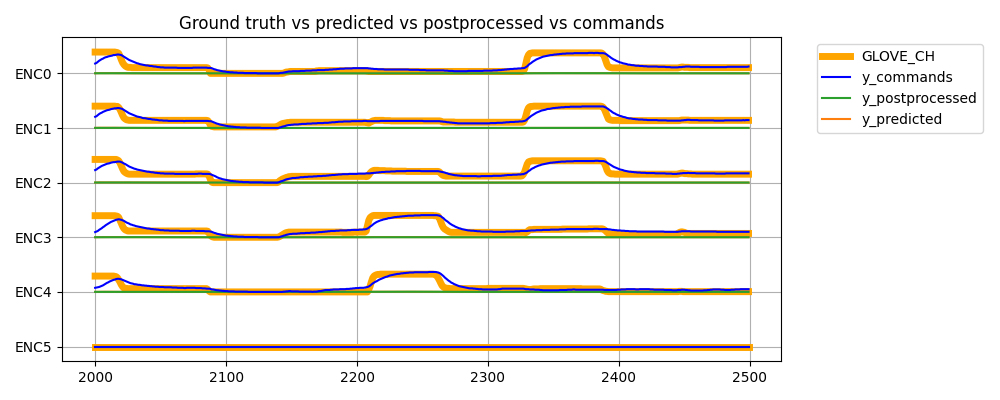

In [42]:
xticks = df_sim[GLOVE_CH].index
dist = -np.arange(len(GLOVE_CH)) * 200

fig, ax = plt.subplots(1, 1,  figsize=(10, 4))

ax.plot(xticks, df_sim[GLOVE_CH] + dist, c='orange', label='GLOVE_CH',linewidth=5)
ax.plot(xticks, y_dct['y_predicted'] + dist, c='C1', label='y_predicted')#
ax.plot(xticks, y_dct['y_postprocessed'] + dist, c='C2', label='y_postprocessed') #
ax.plot(xticks, y_dct['y_commands'] + dist, c='blue', label ='y_commands') #


plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(dist, GLOVE_CH)

# get unique labels
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, bbox_to_anchor=[1.04, 1]) 

plt.grid()
plt.tight_layout()

#plt.savefig(f'../figures/fig_4.png')

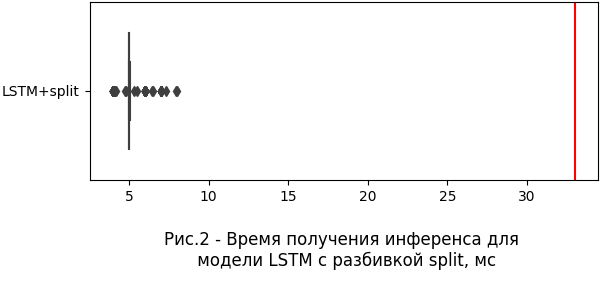

In [65]:
times = pd.DataFrame({'LSTM+split': np.array(y_dct['ts_time'])})

import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(6,3))
fig = sns.boxplot(data=times*1000, orient='h', width=0.65)
#ax.set_xlim(0,0.05)
ax.axvline(33, color='r')#, color='r', ls=':')
ax.set_title('Рис.2 - Время получения инференса для \n модели LSTM с разбивкой split, мc', y=-0.53)
plt.tight_layout(pad=0.15);

#plt.savefig(f'../figures/fig_2.png')

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

# В исходном состоянии буффер - 6 строк из нулей
buff = np.zeros((6,50))

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    #sample_preprocessed = preprocessing(omg_sample)
    sample_preprocessed, buff = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 